In [1]:
import os
import sys
import imageio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from glob import glob
from pathlib import Path
from skimage.filters import gaussian
from skimage.feature import peak_local_max
from skimage.segmentation import watershed, clear_border
from skimage.measure import regionprops



sys.path.append("code/preprocessing/utils/")
from segment2D import *
from segment3D import *
from file_handling import *

In [2]:
vox_to_um = get_voxel_size_35mm()
pix_to_um = get_pixel_size()

In [3]:
path = "data/experimental/raw/tomocube_20250904_B1"
#path = "data/experimental/raw/holomonitor_20240301_B2-6"

fmin=0
fmax=40

#path = "data_tmp/Well_A2-1_zero_corr"
# #mask = imageio.v2.imread(f"data/experimental/raw/holomonitor_20240516_A2-1/mask.tiff")
# im = []
# for f in range(1, 200):

#     #frame = imageio.v2.imread(f"{path}/MDCK-li_reg_zero_corr_fluct_{f}.tiff")
#     frame = imageio.v2.imread(f"{path}/Well A2-1 _reg__Zc0fluct_{f}.tiff")# * (mask > 0)
#     im.append(frame / 100)

# import data
microscope = Path(path).stem.split("_")[0]

if microscope == 'holomonitor':
    pix_to_um = get_pixel_size()
    im = import_holomonitor_stack(path, 
                                    f_min=fmin,
                                    f_max=fmax)

elif microscope == 'tomocube':
    pix_to_um = get_voxel_size_35mm()
    im, h_im = import_tomocube_stack(path, 
                                       h_scaling=vox_to_um[0], 
                                       f_min=fmin, 
                                       f_max=fmax)

# # Tomocube
# fmin = 1
# fmax = 40
# file = "250611.151310.MDCK-parental.001.1per7_5.B3.T001P02"
# folder = "../data/Tomocube/MDCK_11.06.2025/B3P2"
# im, _ = import_tomocube_stack(folder, file, vox_to_um[0], f_min=fmin, f_max=fmax)



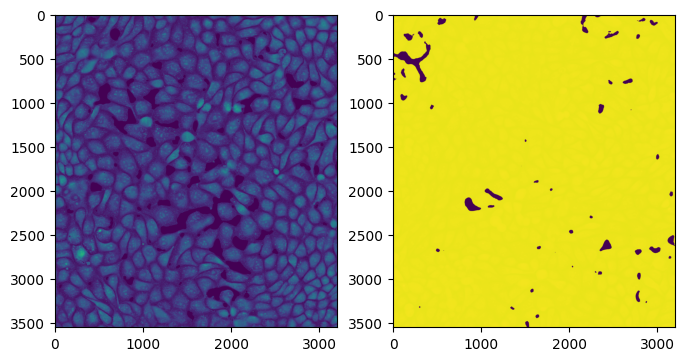

In [4]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(im[0][100:, :3200], vmin=1.37)
ax[1].imshow(im[-1][100:, :3200])

# im = im[:, 100:, :3200]
# h_im = h_im[:, 100:, :3200]

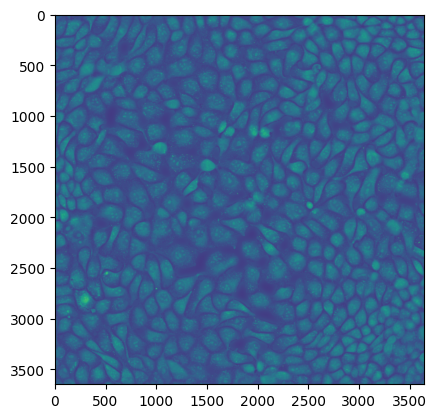

In [210]:
idx = 0

if microscope == 'holomonitor':
    s_high_tmp = 6
    s_low_tmp  = 12
    r0 = 13

if microscope == 'tomocube':
    s_high_tmp = 20
    s_low_tmp  = 1.1*s_high_tmp
    r0 = 12 # times 


im_blur = np.copy(im[idx])
im_tmp  = np.copy(im[idx])
im_blur[im_blur < 1.33] = 1.37#np.mean(im_blur)
im_blur = sc.ndimage.gaussian_filter(im_blur, 40)

im_tmp[im_tmp < 1.33] = im_blur[im_tmp < 1.33]
plt.imshow(im_tmp)

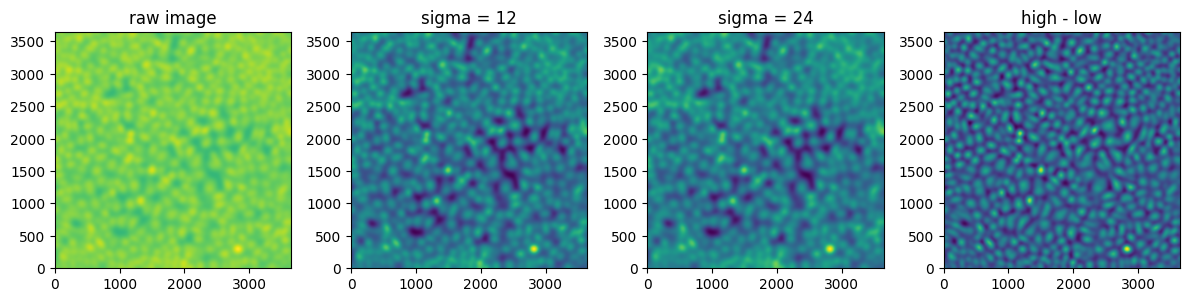

In [ ]:

r0 = 40
tau = 10
s_high_tmp = 12
s_low_tmp  = 24

def particle_size(frame, r0, tau):
    return r0 * 2 ** (-frame / (2*tau))

n_norm    = smoothen_normalize_im(im_blur, s_high_tmp, s_low_tmp, fig=False)
positions1 = peak_local_max(n_norm, min_distance=int(np.round(particle_size(idx, r0, tau*4))))

n_norm    = smoothen_normalize_im(im_blur, 12, 24, fig=True)
positions2 = peak_local_max(n_norm, min_distance=int(np.round(particle_size(idx, r0, tau*4))))

437
430


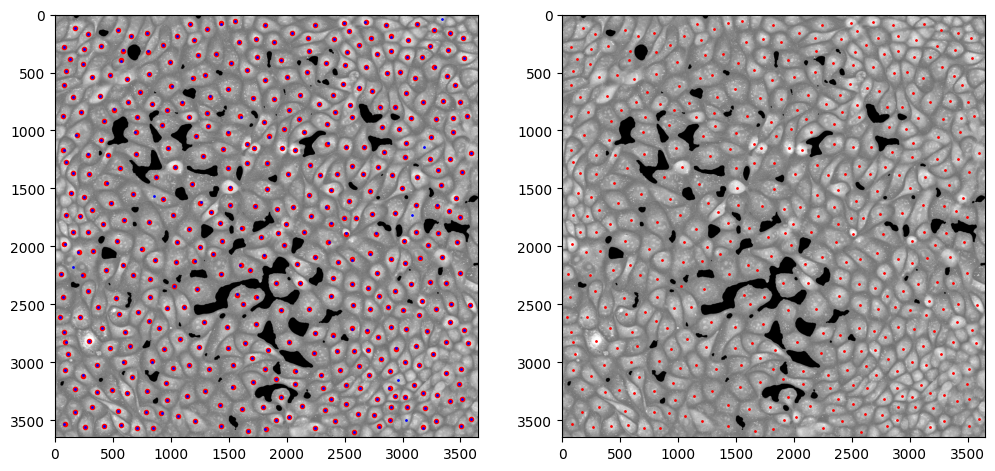

In [214]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(im[idx], cmap="gray", vmin=1.35, vmax=1.4)
ax[0].plot(positions2.T[1], positions2.T[0], 'r.', ms=6)
ax[0].plot(positions1.T[1], positions1.T[0], 'b.', ms=2)

ax[1].imshow(im[idx], cmap="gray", vmin=1.35, vmax=1.4)
ax[1].plot(positions2.T[1], positions2.T[0], 'r.', ms=2)
print(len(positions1))
print(len(positions2))

In [122]:
700 * 10**6 / 550**2

2314.0495867768595

In [ ]:
areas1, _ = get_cell_areas(-n_norm, positions1, im[idx], clear_edge=True)
areas2, _ = get_cell_areas(-n_norm, positions2, im[idx], clear_edge=True)

reg1 = regionprops(areas1, im[idx])
reg2 = regionprops(areas2, im[idx])

pos1 = np.array([cell.centroid_weighted for cell in reg1])
pos2 = np.array([cell.centroid_weighted for cell in reg2])


488
514


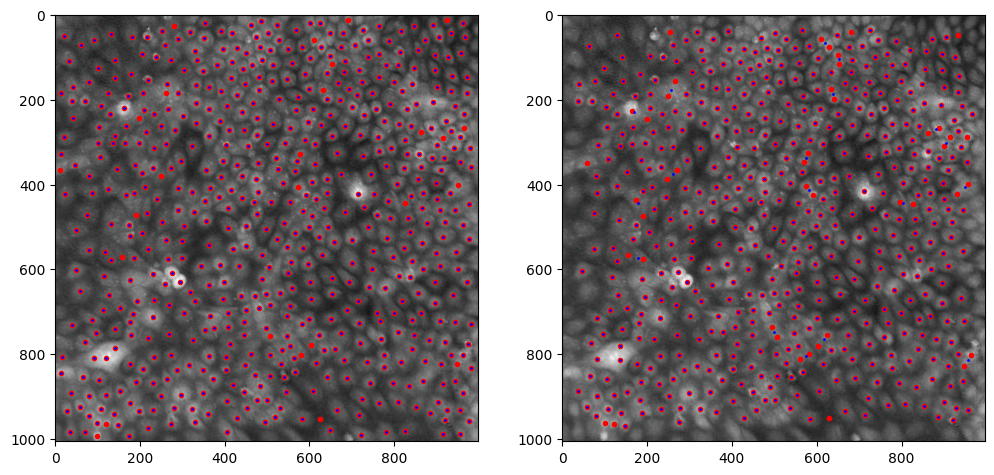

In [135]:

fig, ax = plt.subplots(1,2, figsize=(12, 6))
ax[0].imshow(im[idx], cmap="gray", vmin=0)
ax[0].plot(positions2.T[1], positions2.T[0], 'r.', ms=6)
ax[0].plot(positions1.T[1], positions1.T[0], 'b.', ms=2)

ax[1].imshow(im[idx], cmap="gray", vmin=0)
ax[1].plot(pos2.T[1], pos2.T[0], 'r.', ms=6)
ax[1].plot(pos1.T[1], pos1.T[0], 'b.', ms=2)
print(len(pos1))
print(len(pos2))

In [ ]:
new_pos = []
wrong_pos = []
for x, y in pos_idx:
    if im[idx, x, y] < 1.33:
        wrong_pos.append([int(x), int(y)])
        continue
    else:
        new_pos.append([int(x), int(y)])

new_pos = np.array(new_pos)
wrong_pos = np.array(wrong_pos)

In [136]:
r0 = 13

def particle_size(frame, r0, tau):
    return int(r0 * 2 ** (-frame / (2*tau)))

particle_size(12*12, r0, 16*12)

10